# Data context

This dataset contains 515,000 customer reviews and scoring of 1493 luxury hotels across Europe. Meanwhile, the geographical location of hotels are also provided for further analysis.

*(source: https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe?resource=download)*

# Data content

The csv file contains 17 fields. The description of each field is as below:

- **Hotel_Address**: Address of hotel.

- **Review_Date**: Date when reviewer posted the corresponding review.

- **Average_Score**: Average Score of the hotel, calculated based on the latest comment in the last year.

- **Hotel_Name**: Name of Hotel

- **Reviewer_Nationality**: Nationality of Reviewer

- **Negative_Review**: Negative Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Negative'

- **ReviewTotalNegativeWordCounts**: Total number of words in the negative review.

- **Positive_Review**: Positive Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Positive'

- **ReviewTotalPositiveWordCounts**: Total number of words in the positive review.

- **Reviewer_Score**: Score the reviewer has given to the hotel, based on his/her experience

- **TotalNumberofReviewsReviewerHasGiven**: Number of Reviews the reviewers has given in the past.

- **TotalNumberof_Reviews**: Total number of valid reviews the hotel has.

- **Tags**: Tags reviewer gave the hotel.

- **dayssincereview**: Duration between the review date and scrape date.

- **AdditionalNumberof_Scoring**: There are also some guests who just made a scoring on the service rather than a review. This number indicates how many valid scores without review in there.

- **lat**: Latitude of the hotel

- **lng**: longtitude of the hotel

*(source: https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe?resource=download)*

In [11]:
# Installing
%%capture
!pip install category_encoders
!pip install wordcloud
!pip install spacy
!python -m spacy download en_core_web_sm

# Imports

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import warnings
%matplotlib inline

from datetime import date
import plotly.express as px

from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
import spacy

import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Embedding, Flatten, Dropout, BatchNormalization
from keras.layers.core import Dense
from keras import regularizers
import keras
from keras import Model
from keras.layers import Conv1D, GlobalMaxPooling1D, LSTM
import tensorflow as tf

from google.colab import drive

warnings.filterwarnings('ignore')

# Load data

In [83]:
# Load data into DataFrame
df = pd.read_csv('/content/Hotel_Reviews.csv')

# EDA

In [86]:
# Shape of data
df.shape

(515738, 17)

In [87]:
# Unique values in each column
print(df.nunique())

Hotel_Address                                   1493
Additional_Number_of_Scoring                     480
Review_Date                                      731
Average_Score                                     34
Hotel_Name                                      1492
Reviewer_Nationality                             227
Negative_Review                               330011
Review_Total_Negative_Word_Counts                402
Total_Number_of_Reviews                         1142
Positive_Review                               412601
Review_Total_Positive_Word_Counts                365
Total_Number_of_Reviews_Reviewer_Has_Given       198
Reviewer_Score                                    37
Tags                                           55242
days_since_review                                731
lat                                             1472
lng                                             1472
dtype: int64


In [88]:
# Rows without 'No Negative' in Negative_Review, leave only with content 
nn = df[df['Negative_Review'] != 'No Negative']
nn.head()

Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
5   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                           194    8/3/2017            7.7  Hotel Arena   
2                           194   7/31/2017            7.7  Hotel Arena   
3                           194   7/31/2017            7.7  Hotel Arena   
4                           194   7/24/2017            7.7  Hotel Arena   
5                           194   7/24/2017            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   
2           Australia    Rooms are nice but for elderly a bit difficul...   
3      United Kingdom    My room was dirty and I was afraid to walk ba...   
4         New Zealand    You When I booked with your company on line y...   
5              Poland    Backyard of the hotel is total mess shouldn t...   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                397                     1403   
2                                 42                     1403   
3                                210                     1403   
4                                140                     1403   
5                                 17                     1403   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   
2   Location was good and staff were ok It is cut...   
3   Great location in nice surroundings the bar a...   
4    Amazing location and building Romantic setting    
5   Good restaurant with modern design great chil...   

   Review_Total_Positive_Word_Counts  \
0                                 11   
2                                 21   
3                                 26   
4                                  8   
5                                 20   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           7             2.9   
2                                           9             7.1   
3                                           1             3.8   
4                                           3             6.7   
5                                           1             6.7   

                                                Tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
2  [' Leisure trip ', ' Family with young childre...            3 days   
3  [' Leisure trip ', ' Solo traveler ', ' Duplex...            3 days   
4  [' Leisure trip ', ' Couple ', ' Suite ', ' St...           10 days   
5  [' Leisure trip ', ' Group ', ' Duplex Double ...           10 days   

         lat       lng  
0  52.360576  4.915968  
2  52.360576  4.915968  
3  52.360576  4.915968  
4  52.360576  4.915968  
5  52.360576  4.915968

In [89]:
# Rows without 'No Positive' in Positive_Review, leave only with content 
pp = df[df['Positive_Review'] != 'No Positive']
pp.head()

Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                           194    8/3/2017            7.7  Hotel Arena   
1                           194    8/3/2017            7.7  Hotel Arena   
2                           194   7/31/2017            7.7  Hotel Arena   
3                           194   7/31/2017            7.7  Hotel Arena   
4                           194   7/24/2017            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   
1             Ireland                                         No Negative   
2           Australia    Rooms are nice but for elderly a bit difficul...   
3      United Kingdom    My room was dirty and I was afraid to walk ba...   
4         New Zealand    You When I booked with your company on line y...   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                397                     1403   
1                                  0                     1403   
2                                 42                     1403   
3                                210                     1403   
4                                140                     1403   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   
1   No real complaints the hotel was great great ...   
2   Location was good and staff were ok It is cut...   
3   Great location in nice surroundings the bar a...   
4    Amazing location and building Romantic setting    

   Review_Total_Positive_Word_Counts  \
0                                 11   
1                                105   
2                                 21   
3                                 26   
4                                  8   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           7             2.9   
1                                           7             7.5   
2                                           9             7.1   
3                                           1             3.8   
4                                           3             6.7   

                                                Tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
1  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
2  [' Leisure trip ', ' Family with young childre...            3 days   
3  [' Leisure trip ', ' Solo traveler ', ' Duplex...            3 days   
4  [' Leisure trip ', ' Couple ', ' Suite ', ' St...           10 days   

         lat       lng  
0  52.360576  4.915968  
1  52.360576  4.915968  
2  52.360576  4.915968  
3  52.360576  4.915968  
4  52.360576  4.915968

In [90]:
# Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

In [91]:
# Change column type for Review_Date
df['Review_Date'] = pd.to_datetime(df['Review_Date'])
df.head()

Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                           194  2017-08-03            7.7  Hotel Arena   
1                           194  2017-08-03            7.7  Hotel Arena   
2                           194  2017-07-31            7.7  Hotel Arena   
3                           194  2017-07-31            7.7  Hotel Arena   
4                           194  2017-07-24            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   
1             Ireland                                         No Negative   
2           Australia    Rooms are nice but for elderly a bit difficul...   
3      United Kingdom    My room was dirty and I was afraid to walk ba...   
4         New Zealand    You When I booked with your company on line y...   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                397                     1403   
1                                  0                     1403   
2                                 42                     1403   
3                                210                     1403   
4                                140                     1403   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   
1   No real complaints the hotel was great great ...   
2   Location was good and staff were ok It is cut...   
3   Great location in nice surroundings the bar a...   
4    Amazing location and building Romantic setting    

   Review_Total_Positive_Word_Counts  \
0                                 11   
1                                105   
2                                 21   
3                                 26   
4                                  8   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           7             2.9   
1                                           7             7.5   
2                                           9             7.1   
3                                           1             3.8   
4                                           3             6.7   

                                                Tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
1  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
2  [' Leisure trip ', ' Family with young childre...            3 days   
3  [' Leisure trip ', ' Solo traveler ', ' Duplex...            3 days   
4  [' Leisure trip ', ' Couple ', ' Suite ', ' St...           10 days   

         lat       lng  
0  52.360576  4.915968  
1  52.360576  4.915968  
2  52.360576  4.915968  
3  52.360576  4.915968  
4  52.360576  4.915968

In [92]:
#  Basic statistics for numerical columns
df.describe()

Additional_Number_of_Scoring  Average_Score  \
count                 515738.000000  515738.000000   
mean                     498.081836       8.397487   
std                      500.538467       0.548048   
min                        1.000000       5.200000   
25%                      169.000000       8.100000   
50%                      341.000000       8.400000   
75%                      660.000000       8.800000   
max                     2682.000000       9.800000   

       Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
count                      515738.000000            515738.000000   
mean                           18.539450              2743.743944   
std                            29.690831              2317.464868   
min                             0.000000                43.000000   
25%                             2.000000              1161.000000   
50%                             9.000000              2134.000000   
75%                            23.000000              3613.000000   
max                           408.000000             16670.000000   

       Review_Total_Positive_Word_Counts  \
count                      515738.000000   
mean                           17.776458   
std                            21.804185   
min                             0.000000   
25%                             5.000000   
50%                            11.000000   
75%                            22.000000   
max                           395.000000   

       Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
count                               515738.000000   515738.000000   
mean                                     7.166001        8.395077   
std                                     11.040228        1.637856   
min                                      1.000000        2.500000   
25%                                      1.000000        7.500000   
50%                                      3.000000        8.800000   
75%                                      8.000000        9.600000   
max                                    355.000000       10.000000   

                 lat            lng  
count  512470.000000  512470.000000  
mean       49.442439       2.823803  
std         3.466325       4.579425  
min        41.328376      -0.369758  
25%        48.214662      -0.143372  
50%        51.499981       0.010607  
75%        51.516288       4.834443  
max        52.400181      16.429233

In [93]:
# Amount of na values in all columns
df.isna().sum(axis = 1)

0         0
1         0
2         0
3         0
4         0
         ..
515733    0
515734    0
515735    0
515736    0
515737    0
Length: 515738, dtype: int64

In [94]:
# Amount od null values in all columns
df.isnull().sum()

Hotel_Address                                    0
Additional_Number_of_Scoring                     0
Review_Date                                      0
Average_Score                                    0
Hotel_Name                                       0
Reviewer_Nationality                             0
Negative_Review                                  0
Review_Total_Negative_Word_Counts                0
Total_Number_of_Reviews                          0
Positive_Review                                  0
Review_Total_Positive_Word_Counts                0
Total_Number_of_Reviews_Reviewer_Has_Given       0
Reviewer_Score                                   0
Tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
dtype: int64

In [95]:
# Drop rows with null values
df = df.dropna(how = 'any', axis = 0)

In [96]:
# Check null values
df.isnull().sum()

Hotel_Address                                 0
Additional_Number_of_Scoring                  0
Review_Date                                   0
Average_Score                                 0
Hotel_Name                                    0
Reviewer_Nationality                          0
Negative_Review                               0
Review_Total_Negative_Word_Counts             0
Total_Number_of_Reviews                       0
Positive_Review                               0
Review_Total_Positive_Word_Counts             0
Total_Number_of_Reviews_Reviewer_Has_Given    0
Reviewer_Score                                0
Tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
dtype: int64

In [97]:
# Retrieve day of week from Review_Date column
df['day'] = df['Review_Date'].dt.day_name()

In [98]:
# Amount of reviews grouped by day of week
occur = df.groupby(['day']).size()
display(occur)

day
Friday        44426
Monday        80664
Saturday      51483
Sunday        83433
Thursday      74029
Tuesday      120219
Wednesday     58216
dtype: int64

In [99]:
# Make one column with overall review
df['review'] = df['Negative_Review'] + df['Positive_Review']

In [100]:
# Get rid of 'No Positive' and 'No Negative' reviews in overall column
df['clean_review'] = df['review'].str.replace("No Negative", "").replace("No Positive", "")

In [101]:
# Country from address
df['country'] = [x.split(' ')[-1] for x in df['Hotel_Address'].values]

In [102]:
# Country from address for 2 new dataframes
pp['country'] = [x.split(' ')[-1] for x in pp['Hotel_Address'].values]
nn['country'] = [x.split(' ')[-1] for x in nn['Hotel_Address'].values]

In [103]:
# Day from date for 2 new columns
pp['Review_Date'] = pd.to_datetime(pp['Review_Date'])
nn['Review_Date'] = pd.to_datetime(nn['Review_Date'])

pp['day'] = pp['Review_Date'].dt.day_name()
nn['day'] = nn['Review_Date'].dt.day_name()

In [104]:
# Group by country and day for data without 'No Positive'
occur = pp.groupby(['country', 'day'], as_index = False).size()
p = pd.DataFrame(occur)
p.rename(columns = {'size': 'without_no_pos_by_day'}, inplace = True)
p

country        day  without_no_pos_by_day
0       Austria     Friday                   3398
1       Austria     Monday                   5516
2       Austria   Saturday                   3988
3       Austria     Sunday                   5964
4       Austria   Thursday                   5472
5       Austria    Tuesday                   7861
6       Austria  Wednesday                   4174
7        France     Friday                   5086
8        France     Monday                   8753
9        France   Saturday                   5962
10       France     Sunday                   8945
11       France   Thursday                   8563
12       France    Tuesday                  12603
13       France  Wednesday                   6211
14        Italy     Friday                   3271
15        Italy     Monday                   5532
16        Italy   Saturday                   3645
17        Italy     Sunday                   5583
18        Italy   Thursday                   5148
19        Italy    Tuesday                   7406
20        Italy  Wednesday                   4058
21      Kingdom     Friday                  19478
22      Kingdom     Monday                  38788
23      Kingdom   Saturday                  22837
24      Kingdom     Sunday                  40520
25      Kingdom   Thursday                  33300
26      Kingdom    Tuesday                  60251
27      Kingdom  Wednesday                  27495
28  Netherlands     Friday                   4936
29  Netherlands     Monday                   8478
30  Netherlands   Saturday                   5553
31  Netherlands     Sunday                   8050
32  Netherlands   Thursday                   7871
33  Netherlands    Tuesday                  12408
34  Netherlands  Wednesday                   6105
35        Spain     Friday                   5409
36        Spain     Monday                   8181
37        Spain   Saturday                   6139
38        Spain     Sunday                   9027
39        Spain   Thursday                   8881
40        Spain    Tuesday                  12423
41        Spain  Wednesday                   6523

In [105]:
# Group by country and day for data without 'No Negative'
occur = nn.groupby(['country', 'day'], as_index = False).size()
n = pd.DataFrame(occur)
n.rename(columns = {'size': 'without_no_neg_by_day'}, inplace = True)
n

country        day  without_no_neg_by_day
0       Austria     Friday                   2641
1       Austria     Monday                   4319
2       Austria   Saturday                   3079
3       Austria     Sunday                   4639
4       Austria   Thursday                   4226
5       Austria    Tuesday                   5978
6       Austria  Wednesday                   3208
7        France     Friday                   3913
8        France     Monday                   6765
9        France   Saturday                   4595
10       France     Sunday                   6867
11       France   Thursday                   6607
12       France    Tuesday                   9700
13       France  Wednesday                   4860
14        Italy     Friday                   2603
15        Italy     Monday                   4393
16        Italy   Saturday                   2872
17        Italy     Sunday                   4392
18        Italy   Thursday                   3994
19        Italy    Tuesday                   5788
20        Italy  Wednesday                   3206
21      Kingdom     Friday                  16234
22      Kingdom     Monday                  32731
23      Kingdom   Saturday                  19264
24      Kingdom     Sunday                  33602
25      Kingdom   Thursday                  27905
26      Kingdom    Tuesday                  49385
27      Kingdom  Wednesday                  22961
28  Netherlands     Friday                   3929
29  Netherlands     Monday                   6901
30  Netherlands   Saturday                   4463
31  Netherlands     Sunday                   6501
32  Netherlands   Thursday                   6301
33  Netherlands    Tuesday                   9899
34  Netherlands  Wednesday                   4944
35        Spain     Friday                   4244
36        Spain     Monday                   6402
37        Spain   Saturday                   4795
38        Spain     Sunday                   7108
39        Spain   Thursday                   6898
40        Spain    Tuesday                   9627
41        Spain  Wednesday                   5109

In [106]:
# Make one datframe from above two
n['without_no_pos_by_day'] = p['without_no_pos_by_day']
n

country        day  without_no_neg_by_day  without_no_pos_by_day
0       Austria     Friday                   2641                   3398
1       Austria     Monday                   4319                   5516
2       Austria   Saturday                   3079                   3988
3       Austria     Sunday                   4639                   5964
4       Austria   Thursday                   4226                   5472
5       Austria    Tuesday                   5978                   7861
6       Austria  Wednesday                   3208                   4174
7        France     Friday                   3913                   5086
8        France     Monday                   6765                   8753
9        France   Saturday                   4595                   5962
10       France     Sunday                   6867                   8945
11       France   Thursday                   6607                   8563
12       France    Tuesday                   9700                  12603
13       France  Wednesday                   4860                   6211
14        Italy     Friday                   2603                   3271
15        Italy     Monday                   4393                   5532
16        Italy   Saturday                   2872                   3645
17        Italy     Sunday                   4392                   5583
18        Italy   Thursday                   3994                   5148
19        Italy    Tuesday                   5788                   7406
20        Italy  Wednesday                   3206                   4058
21      Kingdom     Friday                  16234                  19478
22      Kingdom     Monday                  32731                  38788
23      Kingdom   Saturday                  19264                  22837
24      Kingdom     Sunday                  33602                  40520
25      Kingdom   Thursday                  27905                  33300
26      Kingdom    Tuesday                  49385                  60251
27      Kingdom  Wednesday                  22961                  27495
28  Netherlands     Friday                   3929                   4936
29  Netherlands     Monday                   6901                   8478
30  Netherlands   Saturday                   4463                   5553
31  Netherlands     Sunday                   6501                   8050
32  Netherlands   Thursday                   6301                   7871
33  Netherlands    Tuesday                   9899                  12408
34  Netherlands  Wednesday                   4944                   6105
35        Spain     Friday                   4244                   5409
36        Spain     Monday                   6402                   8181
37        Spain   Saturday                   4795                   6139
38        Spain     Sunday                   7108                   9027
39        Spain   Thursday                   6898                   8881
40        Spain    Tuesday                   9627                  12423
41        Spain  Wednesday                   5109                   6523

In [107]:
# Retrieve columns from dataframe for further visualisation (country)
cc = n[['country', 'without_no_neg_by_day', 'without_no_pos_by_day']]

In [108]:
# Group by country and sum rows
c = cc.groupby(['country'], as_index = False).sum()
c

country  without_no_neg_by_day  without_no_pos_by_day
0      Austria                  28090                  36373
1       France                  43307                  56123
2        Italy                  27248                  34643
3      Kingdom                 202082                 242669
4  Netherlands                  42938                  53401
5        Spain                  44183                  56583

In [109]:
# Retrieve columns from dataframe for further visualisation (day)
dd = n[['day', 'without_no_neg_by_day', 'without_no_pos_by_day']]

In [110]:
# Group by day and sum rows
d = dd.groupby(['day'], as_index = False).sum()
d

day  without_no_neg_by_day  without_no_pos_by_day
0     Friday                  33564                  41578
1     Monday                  61511                  75248
2   Saturday                  39068                  48124
3     Sunday                  63109                  78089
4   Thursday                  55931                  69235
5    Tuesday                  90377                 112952
6  Wednesday                  44288                  54566

In [111]:
# Group by Reviewer_Nationality for original frame and sum rows
nat = df.groupby(['Reviewer_Nationality'], as_index = False).count()
na = nat[['Reviewer_Nationality', 'Hotel_Address']]
na.rename(columns = {'Hotel_Address':'Amount'}, inplace = True)
na

Reviewer_Nationality  Amount
0                            520
1      Abkhazia Georgia      151
2           Afghanistan        8
3               Albania      282
4               Algeria      100
..                   ...     ...
222             Vietnam      185
223   Wallis and Futuna        2
224               Yemen       16
225              Zambia       37
226            Zimbabwe       51

[227 rows x 2 columns]

In [112]:
# Group by Reviewer_Nationality for original frame and sum rows
cou = df.groupby(['Hotel_Name'], as_index = False).count()
co = cou[['Hotel_Name', 'Hotel_Address']]
co.rename(columns = {'Hotel_Address':'Amount'}, inplace = True)
co

Hotel_Name  Amount
0                     11 Cadogan Gardens     159
1                               1K Hotel     148
2     25hours Hotel beim MuseumsQuartier     689
3                                     41     103
4     45 Park Lane Dorchester Collection      28
...                                  ...     ...
1470            citizenM London Bankside    1517
1471          citizenM London Shoreditch     838
1472            citizenM Tower of London    1683
1473              every hotel Piccadilly     568
1474                   pentahotel Vienna     129

[1475 rows x 2 columns]

In [113]:
# Add column to original dataframe with is_weekend status
df['is_weekend'] = df['day'].isin(['Saturday', 'Sunday']).replace(True, 1).replace(False, 0)
df

Hotel_Address  \
0        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
...                                                   ...   
515733  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...   
515734  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...   
515735  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...   
515736  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...   
515737  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...   

        Additional_Number_of_Scoring Review_Date  Average_Score  \
0                                194  2017-08-03            7.7   
1                                194  2017-08-03            7.7   
2                                194  2017-07-31            7.7   
3                                194  2017-07-31            7.7   
4                                194  2017-07-24            7.7   
...                              ...         ...            ...   
515733                           168  2015-08-30            8.1   
515734                           168  2015-08-22            8.1   
515735                           168  2015-08-19            8.1   
515736                           168  2015-08-17            8.1   
515737                           168  2015-08-09            8.1   

                   Hotel_Name Reviewer_Nationality  \
0                 Hotel Arena              Russia    
1                 Hotel Arena             Ireland    
2                 Hotel Arena           Australia    
3                 Hotel Arena      United Kingdom    
4                 Hotel Arena         New Zealand    
...                       ...                  ...   
515733  Atlantis Hotel Vienna              Kuwait    
515734  Atlantis Hotel Vienna             Estonia    
515735  Atlantis Hotel Vienna               Egypt    
515736  Atlantis Hotel Vienna              Mexico    
515737  Atlantis Hotel Vienna             Hungary    

                                          Negative_Review  \
0        I am so angry that i made this post available...   
1                                             No Negative   
2        Rooms are nice but for elderly a bit difficul...   
3        My room was dirty and I was afraid to walk ba...   
4        You When I booked with your company on line y...   
...                                                   ...   
515733   no trolly or staff to help you take the lugga...   
515734           The hotel looks like 3 but surely not 4    
515735   The ac was useless It was a hot week in vienn...   
515736                                        No Negative   
515737       I was in 3rd floor It didn t work Free Wife    

        Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                     397                     1403   
1                                       0                     1403   
2                                      42                     1403   
3                                     210                     1403   
4                                     140                     1403   
...                                   ...                      ...   
515733                                 14                     2823   
515734                                 11                     2823   
515735                                 19                     2823   
515736                                  0                     2823   
515737                                 13                     2823   

                                          Positive_Review  ...  \
0        Only the park outside of the hotel was beauti...  ...   
1        No real complaints the hotel was great great ...  ...   
2        Location was good and staff were ok It is cut...  ...   
3        Great loca

In [114]:
# Columns in original dataframe
df.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng', 'day', 'review', 'clean_review',
       'country', 'is_weekend'],
      dtype='object')

In [115]:
# Amount of reviews for each month
rev_date = df.groupby(pd.Grouper(key='Review_Date', axis=0, freq='M')).size()
dates = pd.DataFrame(rev_date)
dates

0
Review_Date       
2015-08-31   19175
2015-09-30   19603
2015-10-31   19346
2015-11-30   17947
2015-12-31   17790
2016-01-31   19357
2016-02-29   18787
2016-03-31   20641
2016-04-30   21364
2016-05-31   22937
2016-06-30   20790
2016-07-31   25718
2016-08-31   27099
2016-09-30   22520
2016-10-31   24189
2016-11-30   17811
2016-12-31   21510
2017-01-31   22501
2017-02-28   19422
2017-03-31   20262
2017-04-30   21274
2017-05-31   23283
2017-06-30   21816
2017-07-31   23264
2017-08-31    4064

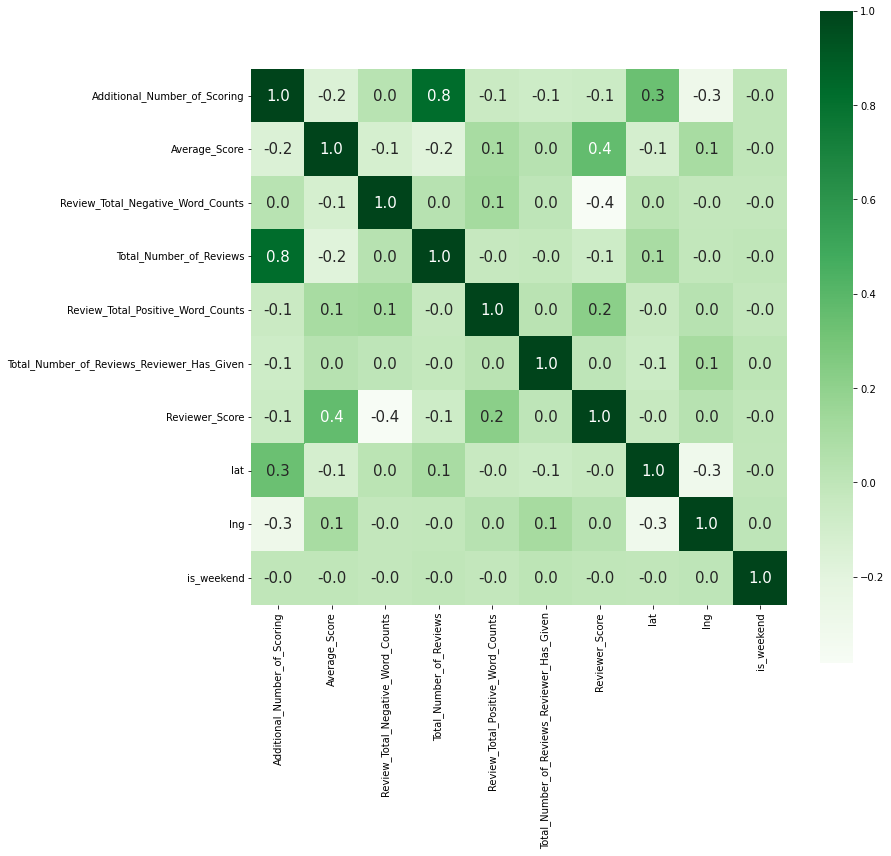

In [116]:
# Correlation matrix before transformations
plt.figure(figsize=(12,12))
count_corr = df.corr()
sns.heatmap(count_corr, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':15}, cmap='Greens')

# Visualization

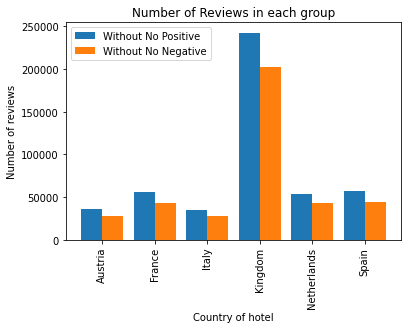

In [ ]:
# Amount of positive and negative reviews separately depends on Hotel Country
X = c['country']
Y = c['without_no_pos_by_day']
Z = c['without_no_neg_by_day']
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Y, 0.4, label = 'Without No Positive')
plt.bar(X_axis + 0.2, Z, 0.4, label = 'Without No Negative')
  
plt.xticks(X_axis, X, rotation = 'vertical')
plt.xlabel("Country of hotel")
plt.ylabel("Number of reviews")
plt.title("Number of Reviews in each group")
plt.legend()
plt.show()

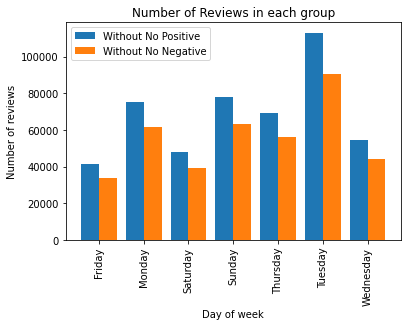

In [ ]:
# Amount of positive and negative reviews separately depends on Day of week
X = d['day']
Y = d['without_no_pos_by_day']
Z = d['without_no_neg_by_day']
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Y, 0.4, label = 'Without No Positive')
plt.bar(X_axis + 0.2, Z, 0.4, label = 'Without No Negative')
  
plt.xticks(X_axis, X, rotation = 'vertical')
plt.xlabel("Day of week")
plt.ylabel("Number of reviews")
plt.title("Number of Reviews in each group")
plt.legend()
plt.show()

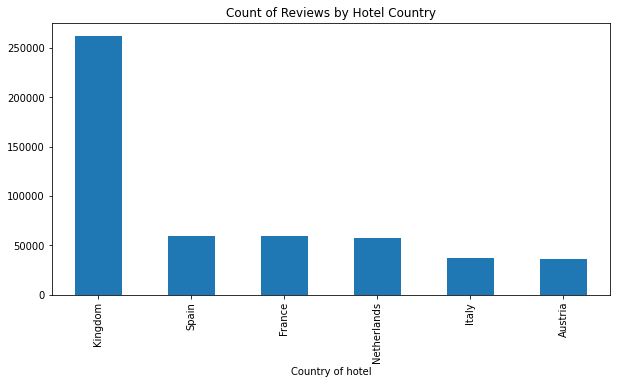

In [ ]:
# Amount of reviews depends on Hotel Country
ax = df['country'].value_counts()\
    .plot(kind='bar',
          title='Count of Reviews by Hotel Country',
          figsize=(10, 5))
ax.set_xlabel('Country of hotel')
plt.show()

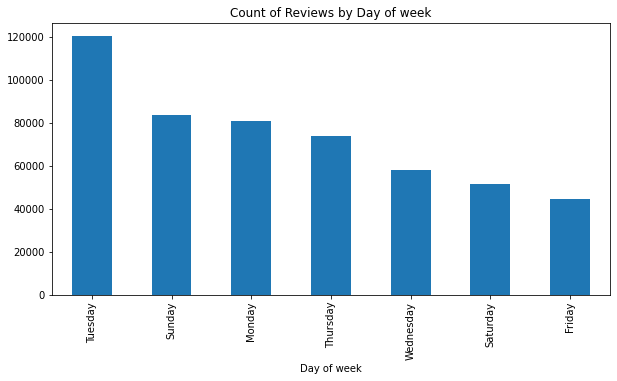

In [ ]:
# Amount of reviews depends on Day of week
ax = df['day'].value_counts() \
    .plot(kind='bar',
          title='Count of Reviews by Day of week',
          figsize=(10, 5))
ax.set_xlabel('Day of week')
plt.show()

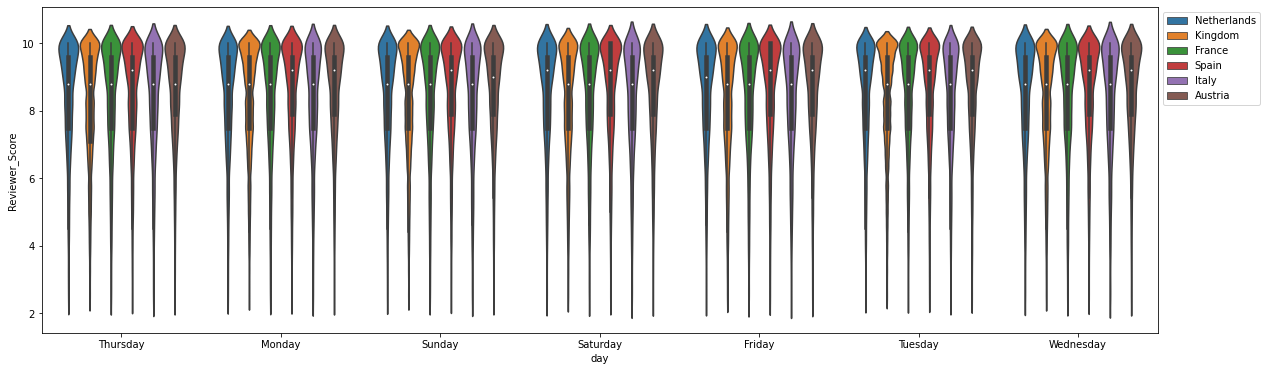

In [ ]:
# Violin plot with Reviewer_Score, day of week and country of hotel
plt.figure(figsize=(20,6))
v = sns.violinplot(x='day', y='Reviewer_Score', data=df, hue='country')
plt.legend(loc=2, bbox_to_anchor=(1,1))

# Sentiment Analysis

In [ ]:
# Remove short words from nn with no 'No_Negative' in Negative_Review
nn = nn.dropna(how = 'any', axis = 0)
not_neg = nn['Negative_Review'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
not_neg.head()

0    angry that made this post available possible s...
2    Rooms nice elderly difficult most rooms story ...
3    room dirty afraid walk barefoot floor which lo...
4    When booked with your company line showed pict...
5    Backyard hotel total mess shouldn happen hotel...
Name: Negative_Review, dtype: object

In [ ]:
# Individual words considered as tokens for above
tokenized_review_n = not_neg.apply(lambda x: x.split())
tokenized_review_n.head()

0    [angry, that, made, this, post, available, pos...
2    [Rooms, nice, elderly, difficult, most, rooms,...
3    [room, dirty, afraid, walk, barefoot, floor, w...
4    [When, booked, with, your, company, line, show...
5    [Backyard, hotel, total, mess, shouldn, happen...
Name: Negative_Review, dtype: object

In [ ]:
# Stem the words for above (root)
stemmer_n = PorterStemmer()

stem_review_n = tokenized_review_n.apply(lambda sentence: [stemmer_n.stem(word) for word in sentence])
stem_review_n.head()

0    [angri, that, made, thi, post, avail, possibl,...
2    [room, nice, elderli, difficult, most, room, s...
3    [room, dirti, afraid, walk, barefoot, floor, w...
4    [when, book, with, your, compani, line, show, ...
5    [backyard, hotel, total, mess, shouldn, happen...
Name: Negative_Review, dtype: object

In [ ]:
# One sentence for above words
sen_review_n = stem_review_n.apply(lambda x: ' '.join(x))
sen_review_n

0         angri that made thi post avail possibl site wh...
2         room nice elderli difficult most room stori wi...
3         room dirti afraid walk barefoot floor which lo...
4         when book with your compani line show pictur r...
5         backyard hotel total mess shouldn happen hotel...
                                ...                        
515731                          park public park garag euro
515733                   trolli staff help take luggag room
515734                                 hotel look like sure
515735                   useless week vienna onli gave more
515737                            floor didn work free wife
Name: Negative_Review, Length: 385435, dtype: object

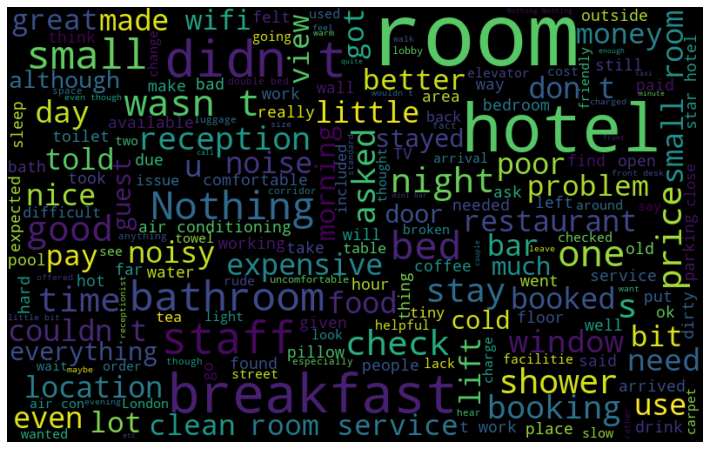

In [ ]:
# Visualize the frequence of negative words
neg_words = " ".join([sentence for sentence in nn['Negative_Review']])
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(neg_words)

# Plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Remove short words from pp with no 'No_Positive' in Positive_Review
pp = pp.dropna(how = 'any', axis = 0)
not_pos = pp['Positive_Review'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
not_pos.head()

0                    Only park outside hotel beautiful
1    real complaints hotel great great location sur...
2    Location good staff were cute hotel breakfast ...
3    Great location nice surroundings restaurant ni...
4           Amazing location building Romantic setting
Name: Positive_Review, dtype: object

In [ ]:
# Individual words considered as tokens for above
tokenized_review_p = pp['Positive_Review'].apply(lambda x: x.split())
tokenized_review_p.head()

0    [Only, the, park, outside, of, the, hotel, was...
1    [No, real, complaints, the, hotel, was, great,...
2    [Location, was, good, and, staff, were, ok, It...
3    [Great, location, in, nice, surroundings, the,...
4    [Amazing, location, and, building, Romantic, s...
Name: Positive_Review, dtype: object

In [ ]:
# Stem the words for above (root)
stemmer_p = PorterStemmer()

stem_review_p = tokenized_review_p.apply(lambda sentence: [stemmer_p.stem(word) for word in sentence])
stem_review_p.head()

0    [onli, the, park, outsid, of, the, hotel, wa, ...
1    [no, real, complaint, the, hotel, wa, great, g...
2    [locat, wa, good, and, staff, were, ok, it, is...
3    [great, locat, in, nice, surround, the, bar, a...
4               [amaz, locat, and, build, romant, set]
Name: Positive_Review, dtype: object

In [ ]:
# One sentence for above words
sen_review_p = stem_review_p.apply(lambda x: ' '.join(x))
sen_review_p

0               onli the park outsid of the hotel wa beauti
1         no real complaint the hotel wa great great loc...
2         locat wa good and staff were ok it is cute hot...
3         great locat in nice surround the bar and resta...
4                           amaz locat and build romant set
                                ...                        
515732    help staff allow me to check in earli as i arr...
515733                                                locat
515734          breakfast wa ok and we got earlier check in
515736    the room are enorm and realli comfort i believ...
515737                                   staff wa veri kind
Name: Positive_Review, Length: 476733, dtype: object

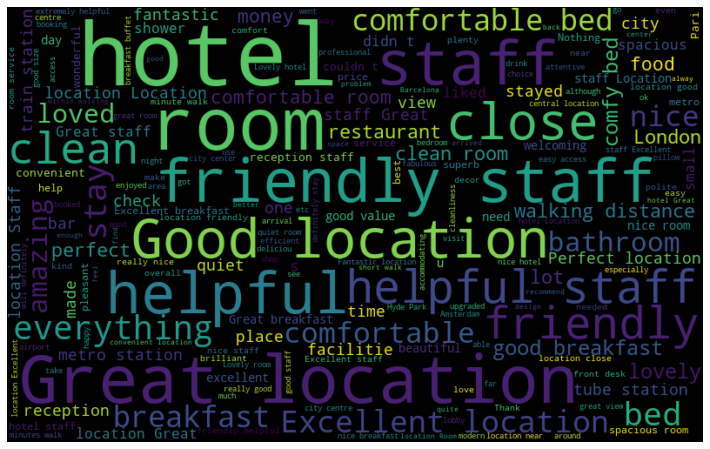

In [ ]:
# Visualize the frequence of positive words
pos_words = " ".join([sentence for sentence in pp['Positive_Review']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(pos_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [157]:
# Remove short words from clean_review for all data
cr = df['clean_review'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
cr.head()

0    angry that made this post available possible s...
1    real complaints hotel great great location sur...
2    Rooms nice elderly difficult most rooms story ...
3    room dirty afraid walk barefoot floor which lo...
4    When booked with your company line showed pict...
Name: clean_review, dtype: object

In [158]:
# Individual words considered as tokens for above
tokenized_review = cr.apply(lambda x: x.split())
tokenized_review.head()

0    [angry, that, made, this, post, available, pos...
1    [real, complaints, hotel, great, great, locati...
2    [Rooms, nice, elderly, difficult, most, rooms,...
3    [room, dirty, afraid, walk, barefoot, floor, w...
4    [When, booked, with, your, company, line, show...
Name: clean_review, dtype: object

In [159]:
# Stem the words for above (root)
stemmer = PorterStemmer()

stem_review= tokenized_review.apply(lambda sentence: [stemmer.stem(word) for word in sentence])
stem_review.head()

0    [angri, that, made, thi, post, avail, possibl,...
1    [real, complaint, hotel, great, great, locat, ...
2    [room, nice, elderli, difficult, most, room, s...
3    [room, dirti, afraid, walk, barefoot, floor, w...
4    [when, book, with, your, compani, line, show, ...
Name: clean_review, dtype: object

In [160]:
# One sentence for above words
sen_review = stem_review.apply(lambda x: ' '.join(x))
sen_review

0         angri that made thi post avail possibl site wh...
1         real complaint hotel great great locat surroun...
2         room nice elderli difficult most room stori wi...
3         room dirti afraid walk barefoot floor which lo...
4         when book with your compani line show pictur r...
                                ...                        
515733             trolli staff help take luggag room locat
515734         hotel look like sure breakfast earlier check
515735       useless week vienna onli gave more airno posit
515736    room enorm realli comfort believ that famili m...
515737            floor didn work free wife staff veri kind
Name: clean_review, Length: 512470, dtype: object

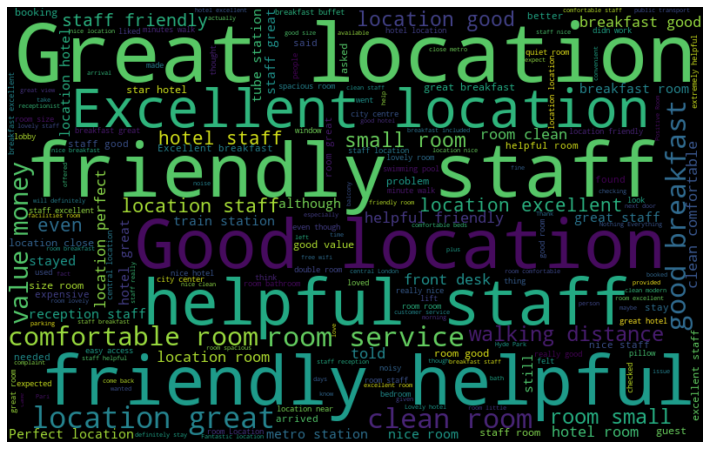

In [161]:
# Visualize the frequence of all words
words = " ".join([sentence for sentence in cr])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
# One sentence for tokenized words
sen_tok_review = tokenized_review.apply(lambda x: ' '.join(x))

In [ ]:
rev_small = sen_tok_review[:50000]

In [ ]:
# Tokenized words with nlp
tab = []
for i in range(len(rev_small)):
  tab.append(nlp(rev_small[i]))

In [ ]:
# NER with table of words and label
tab_text = []
tab_label = []
for i in range(len(tab)):
  for word in tab[i].ents:
    tab_text.append(word.text)
    tab_label.append(word.label_)

In [ ]:
tab_pos = []
tab_word = []
for i in tab:
   for token in i:
     tab_pos.append(token.pos_)
     tab_word.append(token.text)

In [ ]:
# Dataframe with words and labels
words = pd.DataFrame()
words['Word'] = tab_text
words['Label'] = tab_label

In [ ]:
# Group label for all words
wor = words.groupby(['Label'], as_index = False).count()
wor.rename(columns = {'Word':'Amount'}, inplace = True, index = wor['Label'])
wo = pd.DataFrame(wor).sort_values(by = 'Amount')
w = wo.drop(columns = 'Label')
w

Amount
MONEY            32
LAW              33
QUANTITY         94
EVENT           405
LANGUAGE        409
PRODUCT        1064
CARDINAL       1368
FAC            1938
ORDINAL        2182
NORP           2256
WORK_OF_ART    2520
DATE           2697
LOC            2973
TIME           4772
GPE            7106
PERSON         8184
ORG           14350

In [ ]:
# Dataframe with selected words and part of speech
pos = pd.DataFrame()
pos['Word'] = tab_word
pos['Pos'] = tab_pos

In [ ]:
# Group pos for selected words
po = pos.groupby(['Pos'], as_index = False).count()
po.rename(columns = {'Word':'Amount'}, inplace = True, index = po['Pos'])
po = pd.DataFrame(po).sort_values(by = 'Amount')
p1 = po.drop(columns = 'Pos')
p1

Amount
SPACE       2
PUNCT      15
X         214
CCONJ     792
PART      889
INTJ     1160
NUM      1683
DET     12016
SCONJ   15995
PRON    32688
AUX     39506
ADP     40089
PROPN   70458
ADV     99935
VERB   132683
ADJ    204008
NOUN   346007

In [ ]:
# One sentence for tokenized negative words
sen_tok_review_n = tokenized_review_n.apply(lambda x: ' '.join(x).lower())

In [ ]:
idx = pd.Index(range(0, len(sen_tok_review_n), 1))
sen_tok_review_n_ = sen_tok_review_n.set_axis(idx)

In [ ]:
# Tokenized negative words with nlp
tab_n = []
for i in range(len(sen_tok_review_n_)):
  tab_n.append(nlp(sen_tok_review_n_[i]))

KeyboardInterrupt: ignored

In [ ]:
# NER with table of words and label for negative words
tab_text_n = []
tab_label_n = []
for i in range(len(tab_n)):
  for word in tab_n[i].ents:
    tab_text_n.append(word.text)
    tab_label_n.append(word.label_)

In [ ]:
# Dataframe with words and labels for negative
words_n = pd.DataFrame()
words_n['Word'] = tab_text_n
words_n['Label'] = tab_label_n

In [ ]:
# Group label for negative words
wor_n = words_n.groupby(['Label'], as_index = False).count()
wor_n.rename(columns = {'Word':'Amount'}, inplace = True)
wo_n = pd.DataFrame(wor_n).sort_values(by = 'Amount')
wo_n

In [ ]:
# One sentence for tokenized positive words
sen_tok_review_p = tokenized_review_p.apply(lambda x: ' '.join(x).lower())

In [ ]:
idx = pd.Index(range(0, len(sen_tok_review_p), 1))
sen_tok_review_p_ = sen_tok_review_p.set_axis(idx)

In [ ]:
# Tokenized positive words with nlp
tab_p = []
for i in range(len(sen_tok_review_p_)):
  tab_p.append(nlp(sen_tok_review_p_[i]))

In [ ]:
# NER with table of words and label for positive words
tab_text_p = []
tab_label_p = []
for i in range(len(tab_p)):
  for word in tab_p[i].ents:
    tab_text_p.append(word.text)
    tab_label_p.append(word.label_)

In [ ]:
# Dataframe with words and labels for positive
words_p = pd.DataFrame()
words_p['Word'] = tab_text_p
words_p['Label'] = tab_label_p

In [ ]:
# Group label for positive words
wor_p = words_p.groupby(['Label'], as_index = False).count()
wor_p.rename(columns = {'Word':'Amount'}, inplace = True)
wo_p = pd.DataFrame(wor_p).sort_values(by = 'Amount')
wo_p

# Data preprocessing

In [117]:
# Retrieving the columns which will be considered
df1 = df[['Hotel_Name', 'Reviewer_Nationality', 'lat', 'lng', 'clean_review', 'day', 'country', 'Reviewer_Score']]

In [118]:
# Correlation for chosen numeric columns
count_corr = df1.corr()
px.imshow(count_corr, text_auto=True, color_continuous_scale='blues')

In [119]:
# OHE for columns: country i day
ohe_df = pd.get_dummies(df1, columns = ['day', 'country'])
ohe_df

Hotel_Name Reviewer_Nationality        lat        lng  \
0                 Hotel Arena              Russia   52.360576   4.915968   
1                 Hotel Arena             Ireland   52.360576   4.915968   
2                 Hotel Arena           Australia   52.360576   4.915968   
3                 Hotel Arena      United Kingdom   52.360576   4.915968   
4                 Hotel Arena         New Zealand   52.360576   4.915968   
...                       ...                  ...        ...        ...   
515733  Atlantis Hotel Vienna              Kuwait   48.203745  16.335677   
515734  Atlantis Hotel Vienna             Estonia   48.203745  16.335677   
515735  Atlantis Hotel Vienna               Egypt   48.203745  16.335677   
515736  Atlantis Hotel Vienna              Mexico   48.203745  16.335677   
515737  Atlantis Hotel Vienna             Hungary   48.203745  16.335677   

                                             clean_review  Reviewer_Score  \
0        I am so angry that i made this post available...             2.9   
1        No real complaints the hotel was great great ...             7.5   
2        Rooms are nice but for elderly a bit difficul...             7.1   
3        My room was dirty and I was afraid to walk ba...             3.8   
4        You When I booked with your company on line y...             6.7   
...                                                   ...             ...   
515733   no trolly or staff to help you take the lugga...             7.0   
515734   The hotel looks like 3 but surely not 4  Brea...             5.8   
515735   The ac was useless It was a hot week in vienn...             2.5   
515736   The rooms are enormous and really comfortable...             8.8   
515737   I was in 3rd floor It didn t work Free Wife  ...             8.3   

        day_Friday  day_Monday  day_Saturday  day_Sunday  day_Thursday  \
0                0           0             0           0             1   
1                0           0             0           0             1   
2                0           1             0           0             0   
3                0           1             0           0             0   
4                0           1             0           0             0   
...            ...         ...           ...         ...           ...   
515733           0           0             0           1             0   
515734           0           0             1           0             0   
515735           0           0             0           0             0   
515736           0           1             0           0             0   
515737           0           0             0           1             0   

        day_Tuesday  day_Wednesday  country_Austria  country_France  \
0                 0              0                0               0   
1                 0              0                0               0   
2                 0              0                0               0   
3                 0              0                0               0   
4                 0              0                0               0   
...             ...            ...              ...             ...   
515733            0              0                1               0   
515734            0              0                1               0   
515735            0              1                1               0   
515736            0              0                1               0   
515737            0              0                1               0   

        country_Italy  country_Kingdom  country_Netherlands  country_Spain  
0                   0                0                    1              0  
1                   0                0                    1              0  
2                   0                0                    1              0  
3                   0                0                    1              0  
4                   0                0                

In [120]:
# TE for columns: Reviewer_Nationality and Hotel_Name
mean_rev_nat = ohe_df.groupby('Reviewer_Nationality')['Reviewer_Score'].mean().to_dict()
mean_rev_nat

{' ': 8.010192307692307,
 ' Abkhazia Georgia ': 8.351655629139072,
 ' Afghanistan ': 6.875,
 ' Albania ': 8.256382978723405,
 ' Algeria ': 7.777,
 ' American Samoa ': 5.65,
 ' Andorra ': 8.0578125,
 ' Angola ': 8.09032258064516,
 ' Anguilla ': 7.5,
 ' Antarctica ': 8.766666666666667,
 ' Antigua Barbuda ': 8.05,
 ' Argentina ': 8.418786692759296,
 ' Armenia ': 8.097744360902256,
 ' Aruba ': 8.422580645161291,
 ' Australia ': 8.591434540389972,
 ' Austria ': 8.317780634104542,
 ' Azerbaijan ': 7.903676470588236,
 ' Bahamas ': 8.584375,
 ' Bahrain ': 7.93499369482976,
 ' Bangladesh ': 7.597333333333332,
 ' Barbados ': 8.49672131147541,
 ' Belarus ': 8.222994652406417,
 ' Belgium ': 8.17536304456685,
 ' Belize ': 8.2875,
 ' Benin ': 9.166666666666666,
 ' Bermuda ': 8.602912621359224,
 ' Bhutan ': 8.9,
 ' Bolivia ': 8.716666666666667,
 ' Bonaire St Eustatius and Saba ': 9.066666666666668,
 ' Bosnia and Herzegovina ': 8.360425531914894,
 ' Botswana ': 8.204761904761906,
 ' Brazil ': 8.438486

In [121]:
mean_hot_nam = ohe_df.groupby('Hotel_Name')['Reviewer_Score'].mean().to_dict()
mean_hot_nam

{'11 Cadogan Gardens': 8.845283018867924,
 '1K Hotel': 7.861486486486487,
 '25hours Hotel beim MuseumsQuartier': 8.983309143686503,
 '41': 9.711650485436893,
 '45 Park Lane Dorchester Collection': 9.603571428571428,
 '88 Studios': 8.489106753812637,
 '9Hotel Republique': 8.743715846994535,
 'A La Villa Madame': 8.853658536585366,
 'ABaC Restaurant Hotel Barcelona GL Monumento': 8.464516129032257,
 'AC Hotel Barcelona Forum a Marriott Lifestyle Hotel': 8.001384083044982,
 'AC Hotel Diagonal L Illa a Marriott Lifestyle Hotel': 8.398214285714285,
 'AC Hotel Irla a Marriott Lifestyle Hotel': 8.125,
 'AC Hotel Milano a Marriott Lifestyle Hotel': 8.202777777777778,
 'AC Hotel Paris Porte Maillot by Marriott': 8.425333333333333,
 'AC Hotel Sants a Marriott Lifestyle Hotel': 7.921978021978021,
 'AC Hotel Victoria Suites a Marriott Lifestyle Hotel': 8.828888888888889,
 'ADI Doria Grand Hotel': 8.38843537414966,
 'ADI Hotel Poliziano Fiera': 8.042990654205608,
 'ARCOTEL Kaiserwasser Superior': 8

In [122]:
def calc_smooth_mean(df1, df2, cat_name, target, weight):
    # Compute the global mean
    mean = df[target].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(cat_name)[target].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + weight * mean) / (counts + weight)

    # Replace each value by the according smoothed mean
    if df2 is None:
        return df1[cat_name].map(smooth)
    else:
        return df1[cat_name].map(smooth),df2[cat_name].map(smooth.to_dict())

In [123]:
WEIGHT = 5
ohe_df['rev_nat_enc'] = calc_smooth_mean(df1 = ohe_df, df2 = None, cat_name = 'Reviewer_Nationality', target = 'Reviewer_Score', weight = WEIGHT)
ohe_df['hot_nam_enc'] = calc_smooth_mean(df1 = ohe_df, df2 = None, cat_name = 'Hotel_Name', target = 'Reviewer_Score', weight = WEIGHT)

In [124]:
ohe_df

Hotel_Name Reviewer_Nationality        lat        lng  \
0                 Hotel Arena              Russia   52.360576   4.915968   
1                 Hotel Arena             Ireland   52.360576   4.915968   
2                 Hotel Arena           Australia   52.360576   4.915968   
3                 Hotel Arena      United Kingdom   52.360576   4.915968   
4                 Hotel Arena         New Zealand   52.360576   4.915968   
...                       ...                  ...        ...        ...   
515733  Atlantis Hotel Vienna              Kuwait   48.203745  16.335677   
515734  Atlantis Hotel Vienna             Estonia   48.203745  16.335677   
515735  Atlantis Hotel Vienna               Egypt   48.203745  16.335677   
515736  Atlantis Hotel Vienna              Mexico   48.203745  16.335677   
515737  Atlantis Hotel Vienna             Hungary   48.203745  16.335677   

                                             clean_review  Reviewer_Score  \
0        I am so angry that i made this post available...             2.9   
1        No real complaints the hotel was great great ...             7.5   
2        Rooms are nice but for elderly a bit difficul...             7.1   
3        My room was dirty and I was afraid to walk ba...             3.8   
4        You When I booked with your company on line y...             6.7   
...                                                   ...             ...   
515733   no trolly or staff to help you take the lugga...             7.0   
515734   The hotel looks like 3 but surely not 4  Brea...             5.8   
515735   The ac was useless It was a hot week in vienn...             2.5   
515736   The rooms are enormous and really comfortable...             8.8   
515737   I was in 3rd floor It didn t work Free Wife  ...             8.3   

        day_Friday  day_Monday  day_Saturday  day_Sunday  ...  day_Tuesday  \
0                0           0             0           0  ...            0   
1                0           0             0           0  ...            0   
2                0           1             0           0  ...            0   
3                0           1             0           0  ...            0   
4                0           1             0           0  ...            0   
...            ...         ...           ...         ...  ...          ...   
515733           0           0             0           1  ...            0   
515734           0           0             1           0  ...            0   
515735           0           0             0           0  ...            0   
515736           0           1             0           0  ...            0   
515737           0           0             0           1  ...            0   

        day_Wednesday  country_Austria  country_France  country_Italy  \
0                   0                0               0              0   
1                   0                0               0              0   
2                   0                0               0              0   
3                   0                0               0              0   
4                   0                0               0              0   
...               ...              ...             ...            ...   
515733              0                1               0              0   
515734              0                1               0              0   
515735              1                1               0              0   
515736              0                1               0              0   
515737              0                1               0              0   

        country_Kingdom  country_Netherlands  country_Spain  rev_nat_enc  \
0                     0                    1              0     8.273676   
1                     0                    1              0     8.463133   
2                     0                    1              0     8.591389   
3                     0                    1              0    

In [147]:
# Get rid of columns with Hotel_Name and Reviewer_Nationality (replaced by TE)
all = ohe_df[ohe_df.columns.difference(['Hotel_Name', 'Reviewer_Nationality'])]
all

Reviewer_Score                                       clean_review  \
0                  2.9   I am so angry that i made this post available...   
1                  7.5   No real complaints the hotel was great great ...   
2                  7.1   Rooms are nice but for elderly a bit difficul...   
3                  3.8   My room was dirty and I was afraid to walk ba...   
4                  6.7   You When I booked with your company on line y...   
...                ...                                                ...   
515733             7.0   no trolly or staff to help you take the lugga...   
515734             5.8   The hotel looks like 3 but surely not 4  Brea...   
515735             2.5   The ac was useless It was a hot week in vienn...   
515736             8.8   The rooms are enormous and really comfortable...   
515737             8.3   I was in 3rd floor It didn t work Free Wife  ...   

        country_Austria  country_France  country_Italy  country_Kingdom  \
0                     0               0              0                0   
1                     0               0              0                0   
2                     0               0              0                0   
3                     0               0              0                0   
4                     0               0              0                0   
...                 ...             ...            ...              ...   
515733                1               0              0                0   
515734                1               0              0                0   
515735                1               0              0                0   
515736                1               0              0                0   
515737                1               0              0                0   

        country_Netherlands  country_Spain  day_Friday  day_Monday  \
0                         1              0           0           0   
1                         1              0           0           0   
2                         1              0           0           1   
3                         1              0           0           1   
4                         1              0           0           1   
...                     ...            ...         ...         ...   
515733                    0              0           0           0   
515734                    0              0           0           0   
515735                    0              0           0           0   
515736                    0              0           0           1   
515737                    0              0           0           0   

        day_Saturday  day_Sunday  day_Thursday  day_Tuesday  day_Wednesday  \
0                  0           0             1            0              0   
1                  0           0             1            0              0   
2                  0           0             0            0              0   
3                  0           0             0            0              0   
4                  0           0             0            0              0   
...              ...         ...           ...          ...            ...   
515733             0           1             0            0              0   
515734             1           0             0            0              0   
515735             0           0             0            0              1   
515736             0           0             0            0              0   
515737             0           1             0            0              0   

        hot_nam_enc        lat        lng  rev_nat_enc  
0          7.843117  52.360576   4.915968     8.273676  
1          7.843117  52.360576   4.915968     8.463133  
2          7.843117  52.360576   4.915968     8.591389  
3          7.843117  52.360576   4.915968     8.486109  
4          7.843117  52.360576   4.915968     8.654006  
...             ...        ...        ...          ...  
51573

In [167]:
# Scaler for other numerical data: hot_name_enc, lat, lng, rev_nat_enc
all[['hot_nam_enc','lat','lng','rev_nat_enc']] = MinMaxScaler().fit_transform(all[['hot_nam_enc','lat','lng','rev_nat_enc']])
all

Reviewer_Score                                       clean_review  \
0                  2.9   I am so angry that i made this post available...   
1                  7.5   No real complaints the hotel was great great ...   
2                  7.1   Rooms are nice but for elderly a bit difficul...   
3                  3.8   My room was dirty and I was afraid to walk ba...   
4                  6.7   You When I booked with your company on line y...   
...                ...                                                ...   
515733             7.0   no trolly or staff to help you take the lugga...   
515734             5.8   The hotel looks like 3 but surely not 4  Brea...   
515735             2.5   The ac was useless It was a hot week in vienn...   
515736             8.8   The rooms are enormous and really comfortable...   
515737             8.3   I was in 3rd floor It didn t work Free Wife  ...   

        country_Austria  country_France  country_Italy  country_Kingdom  \
0                     0               0              0                0   
1                     0               0              0                0   
2                     0               0              0                0   
3                     0               0              0                0   
4                     0               0              0                0   
...                 ...             ...            ...              ...   
515733                1               0              0                0   
515734                1               0              0                0   
515735                1               0              0                0   
515736                1               0              0                0   
515737                1               0              0                0   

        country_Netherlands  country_Spain  day_Friday  day_Monday  \
0                         1              0           0           0   
1                         1              0           0           0   
2                         1              0           0           1   
3                         1              0           0           1   
4                         1              0           0           1   
...                     ...            ...         ...         ...   
515733                    0              0           0           0   
515734                    0              0           0           0   
515735                    0              0           0           0   
515736                    0              0           0           1   
515737                    0              0           0           0   

        day_Saturday  day_Sunday  day_Thursday  day_Tuesday  day_Wednesday  \
0                  0           0             1            0              0   
1                  0           0             1            0              0   
2                  0           0             0            0              0   
3                  0           0             0            0              0   
4                  0           0             0            0              0   
...              ...         ...           ...          ...            ...   
515733             0           1             0            0              0   
515734             1           0             0            0              0   
515735             0           0             0            0              1   
515736             0           0             0            0              0   
515737             0           1             0            0              0   

        hot_nam_enc       lat       lng  rev_nat_enc  
0          0.572954  0.996423  0.314645     0.511688  
1          0.572954  0.996423  0.314645     0.604476  
2          0.572954  0.996423  0.314645     0.667290  
3          0.572954  0.996423  0.314645     0.615728  
4          0.572954  0.996423  0.314645     0.697957  
...             ...       ...       ...          ...  
515733     0.556029

# Modelling - preparation

In [168]:
# To categorical y
prepared_y = to_categorical(all[['Reviewer_Score']])
print(pd.DataFrame(prepared_y))

         0    1    2    3    4    5    6    7    8    9    10
0       0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1       0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
2       0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
3       0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4       0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
512465  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
512466  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
512467  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
512468  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
512469  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0

[512470 rows x 11 columns]


In [171]:
# Dependent and independent variables
X1 = all[all.columns.difference(['clean_review', 'Reviewer_Score'])]
X2 = sen_review
y = prepared_y

In [184]:
# Train test split of data
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.2, random_state=111)

In [185]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X2_train)

X2_train_tok = word_tokenizer.texts_to_sequences(X2_train)
X2_test_tok = word_tokenizer.texts_to_sequences(X2_test)

In [245]:
word_tokenizer.word_counts

OrderedDict([('noth', 36115),
             ('everi', 10249),
             ('thing', 11089),
             ('love', 44690),
             ('nothimg', 7),
             ('everyth', 29296),
             ('didn', 25049),
             ('like', 35662),
             ('manner', 525),
             ('manag', 6900),
             ('from', 66733),
             ('lobbi', 6769),
             ('spoke', 1180),
             ('when', 33008),
             ('inform', 5035),
             ('about', 17655),
             ('dirti', 5169),
             ('sheet', 2207),
             ('said', 5876),
             ('just', 26112),
             ('imposs', 1239),
             ('that', 63480),
             ('unfortun', 2437),
             ('possibl', 3037),
             ('show', 3024),
             ('pictur', 2380),
             ('made', 13847),
             ('wasn', 12503),
             ('idea', 1354),
             ('doesn', 2115),
             ('believ', 1088),
             ('need', 25143),
             ('spend', 1448),

In [196]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

53052

In [190]:
# Padding all reviews to fixed length 50
maxlen = 50

X2_train_pad = pad_sequences(X2_train_tok, padding = 'post', maxlen=maxlen)
X2_test_pad = pad_sequences(X2_test_tok, padding = 'post', maxlen=maxlen)

# Model 1 - smiple neural network

In [219]:
# Architecture
model1 = Sequential()
model1.add(Dense(16, activation="relu", input_shape = (X1_train.shape[1], )))
model1.add(Dense(8, activation="relu"))
model1.add(Flatten())

model2 = Sequential()
embedding_layer = Embedding(vocab_length, 16, input_length = maxlen, trainable = True)
model2.add(embedding_layer)
model2.add(Dense(16, activation="relu"))
model2.add(Flatten())

combinedInput = keras.layers.concatenate([model1.output, model2.output])
x = Dense(8, activation="relu")(combinedInput)
x = Dense(11, activation="softmax")(x)
model_1 = Model(inputs=[model1.input, model2.input], outputs = x)

In [220]:
# Model compilation
model_1.compile(loss = "binary_crossentropy", optimizer='adam', metrics = ['accuracy'])

In [221]:
# Model summary
model_1.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dense_35_input (InputLayer)    [(None, 17)]         0           []                               
                                                                                                  
 embedding_7_input (InputLayer)  [(None, 50)]        0           []                               
                                                                                                  
 dense_35 (Dense)               (None, 16)           288         ['dense_35_input[0][0]']         
                                                                                                  
 embedding_7 (Embedding)        (None, 50, 16)       848832      ['embedding_7_input[0][0]']      
                                                                                            

In [222]:
# Model history
history1 = model_1.fit(x = [X1_train, X2_train_pad], y = y_train, epochs = 10, verbose = 1, validation_split = 0.2)

Epoch 1/10
10250/10250 [==============================] - 112s 11ms/step - loss: 0.2204 - accuracy: 0.3652 - val_loss: 0.2101 - val_accuracy: 0.3863
Epoch 2/10
10250/10250 [==============================] - 133s 13ms/step - loss: 0.2072 - accuracy: 0.3955 - val_loss: 0.2076 - val_accuracy: 0.3908
Epoch 3/10
10250/10250 [==============================] - 124s 12ms/step - loss: 0.2045 - accuracy: 0.4039 - val_loss: 0.2075 - val_accuracy: 0.3908
Epoch 4/10
10250/10250 [==============================] - 124s 12ms/step - loss: 0.2026 - accuracy: 0.4102 - val_loss: 0.2077 - val_accuracy: 0.3912
Epoch 5/10
10250/10250 [==============================] - 128s 13ms/step - loss: 0.2009 - accuracy: 0.4173 - val_loss: 0.2090 - val_accuracy: 0.3874
Epoch 6/10
10250/10250 [==============================] - 117s 11ms/step - loss: 0.1992 - accuracy: 0.4249 - val_loss: 0.2099 - val_accuracy: 0.3872
Epoch 7/10
10250/10250 [==============================] - 120s 12ms/step - loss: 0.1974 - accuracy: 0.4337

In [223]:
# Predictions on the Test Set
score = model_1.evaluate(x = [X1_test, X2_test_pad], y = y_test, verbose = 1)

3203/3203 [==============================] - 7s 2ms/step - loss: 0.2182 - accuracy: 0.3750


In [224]:
# Model Performance
print("Test Score:", score[0])
print("Test Acc:", score[1])

Test Score: 0.2182091921567917
Test Acc: 0.3749585449695587


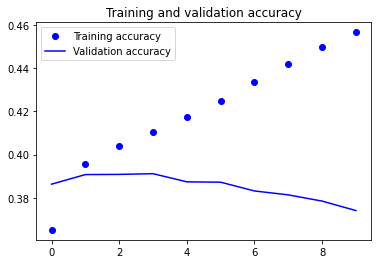

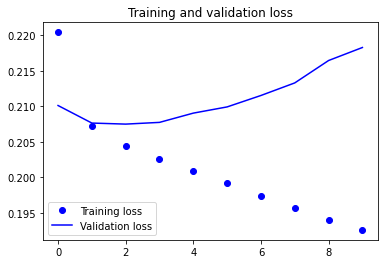

In [225]:
# Model evaluation graph
accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [227]:
# Save model 1
MODEL_PATH = 'drive/My Drive/model_1.h5'

# Now save model in drive
model_1.save(MODEL_PATH)

# Model 2 - dropout and different number of neurons

In [246]:
# Architecture
model3 = Sequential()
model3.add(Dense(8, activation="relu", input_shape = (X1_train.shape[1], )))
model3.add(Dense(4, activation="relu"))
model3.add(Dropout(0.2))
model3.add(Flatten())

model4 = Sequential()
embedding_layer = Embedding(vocab_length, 4, input_length = maxlen, trainable = True)
model4.add(embedding_layer)
model4.add(Dense(8, activation="relu"))
model4.add(Dropout(0.2))
model4.add(Flatten())

combinedInput = keras.layers.concatenate([model3.output, model4.output])
x = Dense(4, activation="relu")(combinedInput)
x = Dense(11, activation="softmax")(x)
model_2 = Model(inputs=[model3.input, model4.input], outputs = x)

In [247]:
# Model compilation
model_2.compile(loss = "binary_crossentropy", optimizer='adam', metrics = ['accuracy'])

In [248]:
# Model summary
model_2.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dense_60_input (InputLayer)    [(None, 17)]         0           []                               
                                                                                                  
 embedding_12_input (InputLayer  [(None, 50)]        0           []                               
 )                                                                                                
                                                                                                  
 dense_60 (Dense)               (None, 8)            144         ['dense_60_input[0][0]']         
                                                                                                  
 embedding_12 (Embedding)       (None, 50, 4)        212208      ['embedding_12_input[0][0]

In [249]:
# Model history
history2 = model_2.fit(x = [X1_train, X2_train_pad], y = y_train, epochs = 10, verbose = 1, validation_split = 0.2)

Epoch 1/10
10250/10250 [==============================] - 61s 6ms/step - loss: 0.2259 - accuracy: 0.3515 - val_loss: 0.2130 - val_accuracy: 0.3797
Epoch 2/10
10250/10250 [==============================] - 59s 6ms/step - loss: 0.2129 - accuracy: 0.3814 - val_loss: 0.2107 - val_accuracy: 0.3834
Epoch 3/10
10250/10250 [==============================] - 57s 6ms/step - loss: 0.2107 - accuracy: 0.3882 - val_loss: 0.2089 - val_accuracy: 0.3882
Epoch 4/10
10250/10250 [==============================] - 69s 7ms/step - loss: 0.2079 - accuracy: 0.3932 - val_loss: 0.2075 - val_accuracy: 0.3909
Epoch 5/10
10250/10250 [==============================] - 58s 6ms/step - loss: 0.2068 - accuracy: 0.3960 - val_loss: 0.2077 - val_accuracy: 0.3883
Epoch 6/10
10250/10250 [==============================] - 59s 6ms/step - loss: 0.2061 - accuracy: 0.3977 - val_loss: 0.2073 - val_accuracy: 0.3919
Epoch 7/10
10250/10250 [==============================] - 59s 6ms/step - loss: 0.2056 - accuracy: 0.3999 - val_loss: 0

In [250]:
# Predictions on the Test Set
score = model_2.evaluate(x = [X1_test, X2_test_pad], y = y_test, verbose = 1)

3203/3203 [==============================] - 8s 2ms/step - loss: 0.2082 - accuracy: 0.3895


In [ ]:
# Model Performance
print("Test Score:", score[0])
print("Test Acc:", score[1])

Test Score: 0.12912333011627197
Test Acc: 0.22495950758457184


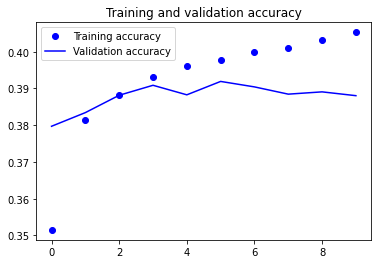

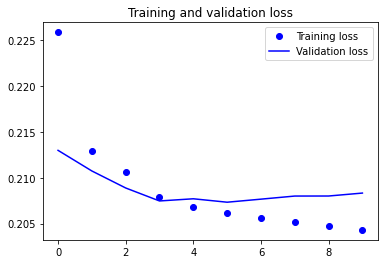

In [251]:
# Model evaluation graph
accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [252]:
# Save model 2
MODEL_PATH = 'drive/My Drive/model_2.h5'

# Now save model in drive
model_2.save(MODEL_PATH)

# Model 3 - LSTM

In [279]:
# Architecture
model5 = Sequential()
model5.add(Dense(8, activation="relu", input_shape = (X1_train.shape[1], )))
model5.add(Dense(4, activation="relu"))
model5.add(Dropout(0.2))
model5.add(Flatten())

model6 = Sequential()
embedding_layer = Embedding(vocab_length, 4, input_length = maxlen, trainable = True)
model6.add(embedding_layer)
model6.add(LSTM(8, activation="relu", input_shape = (10,)))
model6.add(Dropout(0.2))
model6.add(Flatten())

combinedInput = keras.layers.concatenate([model5.output, model6.output])
x = Dense(4, activation="relu")(combinedInput)
x = Dense(11, activation="softmax")(x)
model_3 = Model(inputs=[model5.input, model6.input], outputs = x)

In [280]:
# Model compilation
model_3.compile(loss = "binary_crossentropy", optimizer='adam', metrics = ['accuracy'])

In [281]:
# Model summary
model_3.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dense_81_input (InputLayer)    [(None, 17)]         0           []                               
                                                                                                  
 embedding_21_input (InputLayer  [(None, 50)]        0           []                               
 )                                                                                                
                                                                                                  
 dense_81 (Dense)               (None, 8)            144         ['dense_81_input[0][0]']         
                                                                                                  
 embedding_21 (Embedding)       (None, 50, 4)        212208      ['embedding_21_input[0][0]

In [282]:
# Model history
history3 = model_3.fit(x = [X1_train, X2_train_pad], y = y_train, epochs = 10, verbose = 1, validation_split = 0.2)

Epoch 1/10
10250/10250 [==============================] - 267s 26ms/step - loss: 0.2362 - accuracy: 0.3152 - val_loss: 0.2162 - val_accuracy: 0.3588
Epoch 2/10
10250/10250 [==============================] - 250s 24ms/step - loss: 0.2159 - accuracy: 0.3655 - val_loss: 0.2106 - val_accuracy: 0.3826
Epoch 3/10
10250/10250 [==============================] - 266s 26ms/step - loss: 0.2118 - accuracy: 0.3803 - val_loss: 0.2099 - val_accuracy: 0.3844
Epoch 4/10
10250/10250 [==============================] - 253s 25ms/step - loss: 0.2099 - accuracy: 0.3872 - val_loss: 0.2091 - val_accuracy: 0.3882
Epoch 5/10
10250/10250 [==============================] - 248s 24ms/step - loss: 0.2085 - accuracy: 0.3925 - val_loss: 0.2086 - val_accuracy: 0.3889
Epoch 6/10
10250/10250 [==============================] - 247s 24ms/step - loss: 0.2074 - accuracy: 0.3965 - val_loss: 0.2092 - val_accuracy: 0.3898
Epoch 7/10
10250/10250 [==============================] - 256s 25ms/step - loss: 0.2065 - accuracy: 0.3998

In [283]:
# Predictions on the Test Set
score = model_3.evaluate(x = [X1_test, X2_test_pad], y = y_test, verbose = 1)

3203/3203 [==============================] - 23s 7ms/step - loss: 0.2092 - accuracy: 0.3873


In [284]:
# Model Performance
print("Test Score:", score[0])
print("Test Acc:", score[1])

Test Score: 0.20917318761348724
Test Acc: 0.38734951615333557


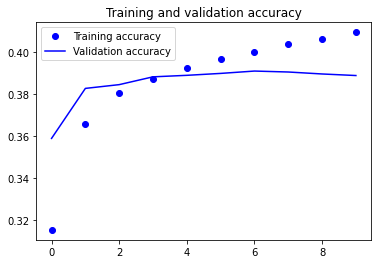

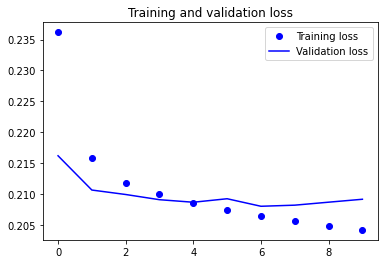

In [285]:
# Model evaluation graph
accuracy = history3.history['accuracy']
val_accuracy = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [295]:
# Save model 3
MODEL_PATH = 'drive/My Drive/model_3.h5'

# Now save model in drive
model_3.save(MODEL_PATH)

# Model 4 - sigmoid instead of relu


In [286]:
# Architecture
model7 = Sequential()
model7.add(Dense(8, activation="sigmoid", input_shape = (X1_train.shape[1], )))
model7.add(Dense(4, activation="sigmoid"))
model7.add(Dropout(0.2))
model7.add(Flatten())

model8 = Sequential()
embedding_layer = Embedding(vocab_length, 4, input_length = maxlen, trainable = True)
model8.add(embedding_layer)
model8.add(LSTM(8, activation="sigmoid", input_shape = (10,)))
model8.add(Dropout(0.2))
model8.add(Flatten())

combinedInput = keras.layers.concatenate([model7.output, model8.output])
x = Dense(4, activation="sigmoid")(combinedInput)
x = Dense(11, activation="softmax")(x)
model_4 = Model(inputs=[model7.input, model8.input], outputs = x)

In [288]:
# Model summary
model_4.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dense_85_input (InputLayer)    [(None, 17)]         0           []                               
                                                                                                  
 embedding_22_input (InputLayer  [(None, 50)]        0           []                               
 )                                                                                                
                                                                                                  
 dense_85 (Dense)               (None, 8)            144         ['dense_85_input[0][0]']         
                                                                                                  
 embedding_22 (Embedding)       (None, 50, 4)        212208      ['embedding_22_input[0][0]

In [289]:
# Model compilation
model_4.compile(loss = "binary_crossentropy", optimizer='adam', metrics = ['accuracy'])

In [290]:
# Model history
history4 = model_4.fit(x = [X1_train, X2_train_pad], y = y_train, epochs = 10, verbose = 1, validation_split = 0.2)

Epoch 1/10
10250/10250 [==============================] - 270s 26ms/step - loss: 0.2603 - accuracy: 0.2422 - val_loss: 0.2466 - val_accuracy: 0.2555
Epoch 2/10
10250/10250 [==============================] - 262s 26ms/step - loss: 0.2368 - accuracy: 0.2889 - val_loss: 0.2302 - val_accuracy: 0.3017
Epoch 3/10
10250/10250 [==============================] - 257s 25ms/step - loss: 0.2300 - accuracy: 0.3168 - val_loss: 0.2274 - val_accuracy: 0.3197
Epoch 4/10
10250/10250 [==============================] - 256s 25ms/step - loss: 0.2284 - accuracy: 0.3191 - val_loss: 0.2264 - val_accuracy: 0.3259
Epoch 5/10
10250/10250 [==============================] - 262s 26ms/step - loss: 0.2281 - accuracy: 0.3232 - val_loss: 0.2267 - val_accuracy: 0.3205
Epoch 6/10
10250/10250 [==============================] - 255s 25ms/step - loss: 0.2270 - accuracy: 0.3292 - val_loss: 0.2267 - val_accuracy: 0.3341
Epoch 7/10
10250/10250 [==============================] - 293s 29ms/step - loss: 0.2275 - accuracy: 0.3273

In [291]:
# Predictions on the Test Set
score = model_4.evaluate(x = [X1_test, X2_test_pad], y = y_test, verbose = 1)

3203/3203 [==============================] - 17s 5ms/step - loss: 0.2278 - accuracy: 0.3177


In [292]:
# Model Performance
print("Test Score:", score[0])
print("Test Acc:", score[1])

Test Score: 0.2278091311454773
Test Acc: 0.3177064061164856


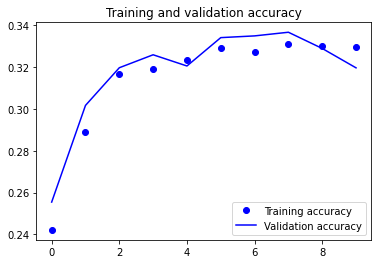

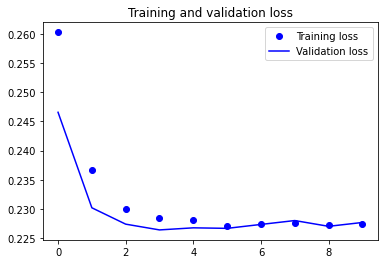

In [293]:
# Model evaluation graph
accuracy = history4.history['accuracy']
val_accuracy = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [294]:
# Save model 4
MODEL_PATH = 'drive/My Drive/model_4.h5'

# Now save model in drive
model_4.save(MODEL_PATH)